In [1]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
df = pd.read_json("017_after_kaldi_anchor_separated.jsonl", lines = True)


In [2]:
df[df.kaldi_transcript == ""].shape[0] / df.shape[0]

0.14298675376519687

We have 15% of instances where Kaldi could not find transcriptions

In [3]:
c = df[df.kaldi_transcript != ""]
(c.end - c.start ).sum()/60**2


69.477

The remaining parts make up for 68 hours of data. Let us see how the transcriptions look like and if they are stable:

Let's check if any files are missing:

In [4]:
df["segment_file"] = df.apply(lambda row:
    row["file"].replace(".wav", "").replace("audio", "seg_audio") + f'__{row["start"]:.1f}__{row["end"]:.1f}__.wav',
    axis=1
)

for file in df.segment_file:
    from pathlib import Path
    p = Path(file)
    if not p.exists():
        print("Segment", p, "does not exist!")



Optional step:

delete rows where we have empty kaldi outputs and delete corresponding audio files:

In [5]:
filtered_df = df[df.kaldi_transcript != ""]

loc = Path("seg_audio")
for segmentfile in loc.glob("*.wav"):
    if str(segmentfile) not in filtered_df["segment_file"]:
        # segmentfile.unlink()
        continue

Let's transform the string representations into proper pythonic lists:

In [6]:
from ast import literal_eval

filtered_df.loc[:, "kaldi_transcript"] = filtered_df.kaldi_transcript.str.replace("πππ", r"<anchor_end>").str.replace("ππ", r"<anchor_start>").str.replace("<unk>", "<anchor_start>")
filtered_df.loc[:, "kaldi_words"] = filtered_df.kaldi_words.str.replace("πππ", r"<anchor_end>").str.replace("ππ", r"<anchor_start>").str.replace("<unk>", "<anchor_start>")

filtered_df.loc[:, "kaldi_words"] = filtered_df.kaldi_words.apply(literal_eval)
filtered_df.loc[:, "kaldi_word_ends"] = filtered_df.kaldi_word_ends.apply(literal_eval)
filtered_df.loc[:, "kaldi_word_starts"] = filtered_df.kaldi_word_starts.apply(literal_eval)



/home/rupnik/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
filtered_df.to_json("018_juzne_vesti_anchor_separated.jsonl", lines=True, orient="records")

In [8]:
filtered_df.columns

Index(['file', 'start', 'end', 'asr_transcription', 'webpage_transcript',
       'ratio', 'text', 'kaldi_transcript', 'kaldi_words', 'kaldi_word_starts',
       'kaldi_word_ends', 'segment_file'],
      dtype='object')

In [17]:
#filtered_df[['file', 'asr_transcription', "webpage_transcript",'kaldi_transcript']].head(50)

In [10]:
corpus = pd.read_json("020_JV_with_metadata.jsonl", orient="records", lines=True)
corpus = corpus["path guest_name guest_description host".split()]
corpus.columns, filtered_df.columns

(Index(['path', 'guest_name', 'guest_description', 'host'], dtype='object'),
 Index(['file', 'start', 'end', 'asr_transcription', 'webpage_transcript',
        'ratio', 'text', 'kaldi_transcript', 'kaldi_words', 'kaldi_word_starts',
        'kaldi_word_ends', 'segment_file'],
       dtype='object'))

In [11]:
merged_df = pd.merge(
    left=filtered_df,
    right = corpus,
    how = "left",
    left_on="file",
    right_on="path"
)

merged_df = merged_df["file start end asr_transcription kaldi_transcript guest_name guest_description host kaldi_words kaldi_word_starts kaldi_word_ends segment_file".split()]

In [12]:
from Levenshtein import distance as lev

def calculate_average_distance(s1, s2):
    s1 = s1.replace("<anchor_start>", "").replace("<anchor_end>", "")
    s2 = s2.replace("<anchor_start>", "").replace("<anchor_end>", "")
    distances = [lev(w1, w2) for w1, w2 in  zip(s1.split(), s2.split())]
    from numpy import mean
    return mean(distances)


def calculate_similarity_ratio(s1, s2):
    s1 = s1.replace("<anchor_start>", "").replace("<anchor_end>", "")
    s2 = s2.replace("<anchor_start>", "").replace("<anchor_end>", "")
    from fuzzywuzzy import fuzz
    ratio = fuzz.ratio(s1, s2)
    return ratio

merged_df["average_distance"] = merged_df.apply(
    lambda row: calculate_average_distance(row["asr_transcription"], row["kaldi_transcript"]),
    axis=1
    )
merged_df["similarity_ratio"] = merged_df.apply(
    lambda row: calculate_similarity_ratio(row["asr_transcription"], row["kaldi_transcript"]),
    axis=1
    )

In [13]:
merged_df.to_json("021_JV_segments_with_metadata.jsonl", orient="records", lines=True)

In [49]:
merged_df["asr_len"] = merged_df.asr_transcription.str.len()

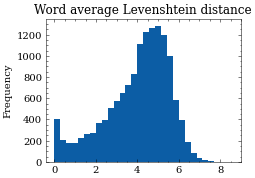

In [14]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])


merged_df.average_distance.plot.hist(bins=30)
plt.title("Word average Levenshtein distance")
plt.show()


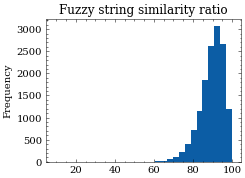

In [15]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

merged_df.similarity_ratio.plot.hist(bins=30)
plt.title("Fuzzy string similarity ratio")

plt.show()

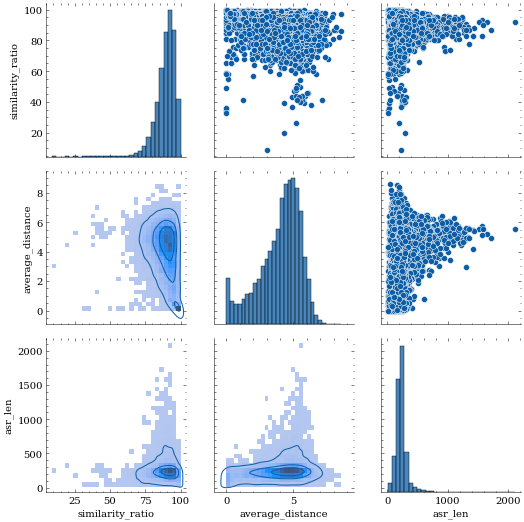

In [69]:
import seaborn as sns

# b = sns.pairplot(data=merged_df, vars=["similarity_ratio", "average_distance"], kind="scatter", diag_kind="kde")
# b.map_lower(sns.histplot, bins=30)



g = sns.PairGrid(data=merged_df, vars=["similarity_ratio", "average_distance", "asr_len"],
diag_sharey=False, 
# hue="asr_len",
# corner=True
)
g.map_lower(sns.histplot, bins=30)
g.map_diag(sns.histplot, bins=30)
g.map_lower(sns.kdeplot, levels=4)
g.map_upper(sns.scatterplot)

# plt.savefig("images/018_pairplot.png", dpi=100, transparent=False, facecolor="white")
plt.show()


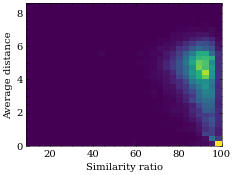

In [20]:
plt.hist2d(merged_df.similarity_ratio, merged_df.average_distance, bins=30)
plt.xlabel("Similarity ratio")
plt.ylabel("Average distance")
plt.show()

In [88]:
merged_df["asr_transcription kaldi_transcript average_distance similarity_ratio".split()].sort_values(by="similarity_ratio").iloc[250:300, :]

,asr_transcription,kaldi_transcript,average_distance,similarity_ratio
13917,jesrž i suština svega toga jasno na početku svoje da kaže tako političke karijere bilisti u demokratskoj stranci srbije tako je jedan kratak možemo reći kaperd znači ja sam u suštini 200. godine sa grupom ljudi bio je osnivač demokratstranke srbije odnosno ovštansko odbora umitrodu,je srž i suština svega <anchor_start> jasno na početku svoje političke karijere bili ste i u dssu jedna kratak period<anchor_end> nije kratak period u suštini od dvije tisuće godine sa grupom ljudi bio i osnivač dss odnosno opštinskog odbora u dimitrovgradu,5.050000,72
5201,ali nisu upoznati sa problematikom nisu prošle edukacije ja sam prošao i ja mislim t ili četii obuke i komandanata za dobroižne situacije etačeunutrašnji poslao kažem osnovni problem je,ali nisu upoznati sa problematikom nisu prošli edukacije ja sam prošao tri ili četiti obuke osnovni problem je,1.888889,72
2035,ali gimnazija svetosor marković koja i onako i prošlu godine upisivalo oko 70 učenika više od ostalih gimnazija zadržala isti broj mesta zašto ta gimnazija zadržala isti broj mesta,podeljen među svim školama uključujući i gimnazije <anchor_start> ali gimnazija svetozar marković koja je i prošle godine upisivala oko sedamdeset učenika više od ostalih gimnazija zadržala je isti broj mesta zašto je ta gimnazija zadržala isti broj mesta a ostale<anchor_end> i juče sam rekao i danas ponavljam,5.517241,72
5034,koji je postojao nešto ste vi rodili ta organizacija koja je bila ta organizacija koja je bila narodna organizaciju dakle organizacija građana nije bila partnijska ali je ima ideal socijalizma ona je u svom sistemu imala hidu 400 zapošlenih dakle to bila potpuno jedna,koji je postojao pre nego što ste se vi rodili ta organizacija koja je bila narodna organizacija organizacija građana nije bila partijska ali ima ideal socijalizma ona je u svom sistemu imala jedančetristo zapošljenih to je bila jedna sa aspekta ekonomskog razvoja potpuno trivijalna institucija ali je ta institucija koja je bila,5.818182,72
2114,u dva slučaja to je festival umetničke igre beogradski festival igre,u dva slučaja to je beogradski festival umetničke igre,3.444444,72
10244,e to je pitanje na koje moramo svi zajedno da dobijemo odgovor žrtve mediji presvega 7 sila ili koja sila,to je pitanje na koje svi zajedno moramo da tražimo odgovor mi žrtve vi mediji kao sedma sila,4.500000,72
12415,njih 107 imaju dug od 500 kiljada do 3 milijuna i 10o a njih 34 imaju od milijun do 3 milijuna i 1to nažalost i po priznanju zaposlenih u distribuciji jer imali smo više kontapi s njima,njih sto sedam imaju dug od petstonula do tristonula a njih trideset četiri imaju od jedannulanula do tristonula na žalost po priznanju zaposlenih u distribuciji jer imali smo više kontakta sa njima,5.718750,72
12887,hvalagstojemojime aleksandar stanko vi ste pratili misiju 15 minuta prijetnoi,je aleksandar stankov a vi ste pratili emisiju petnaest minuta,5.400000,72
10257,a to ne znam da li smo spomenuli već spominju se cene 08 do 12 eura po kvadratnom metru pa puto 25 hilua kvadratnih metara negdje sam pročitao 15 euro,ne znam da li smo to već pomenuli ali pominju se cene od nula i osamdeset do jedan i dvadeset evra po kvadratnom metru pa puta dvadeset pet tisuća kvadratnih metara a negde sam pročitao,4.133333,72
2148,prateći program prije svega mislim da wold newsex staz ali sačekat ćemo kažem neka druga i bolja vremena ovo je jedan,prateći program sočekaćemo neka druga i bolja vremena ovo je jedan,3.727273,72
